In [1]:
MULTIMODAL_SDK_PATH = "/home/dstratton/PycharmProjects/InterpretableMultimodal/CMU-MultimodalSDK"
import sys
sys.path.append(MULTIMODAL_SDK_PATH)

In [3]:
import mmsdk
from mmsdk import mmdatasdk as md
DATASET = md.cmu_mosi
DATA_PATH = "cmumosi"
train_split = DATASET.standard_folds.standard_train_fold
dev_split = DATASET.standard_folds.standard_valid_fold
test_split = DATASET.standard_folds.standard_test_fold

In [ ]:
from utils import load_dataset
data = load_dataset()

In [ ]:
%%capture
dataset = md.mmdataset({
    'CMU_MOSI_TimestampedWords': DATA_PATH + '/CMU_MOSI_TimestampedWords.csd',
    'CMU_MOSI_Opinion_Labels': DATA_PATH + '/CMU_MOSI_Opinion_Labels.csd'
})

In [ ]:
%%capture
dataset.align('CMU_MOSI_Opinion_Labels')

In [9]:
segment_ids = list(dataset['CMU_MOSI_TimestampedWords'].keys())
# filter for test set
segment_ids = [vid for vid in segment_ids if any(substring in vid for substring in test_split)]

In [10]:
# getting data from test set
sentences = []
labels = []
for video_id in segment_ids:
    sentence = []
    for word in dataset['CMU_MOSI_TimestampedWords'][video_id]['features']:
        if word[0] != b'sp':
            sentence.append(word[0].decode('utf-8'))
    sent = ' '.join(sentence)
    sentences.append(sent)
    labels.append(dataset['CMU_MOSI_Opinion_Labels'][video_id]['features'][0][0])
    # you can also store interval information from dataset['CMU_MOSI_TimestampedWords'][video_id]['intervals'] if needed

import pandas as pd
text_data = pd.DataFrame({'text': sentences, 'labels': labels})

In [11]:
# https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-imdb").cuda()
pred = transformers.pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

In [12]:
predictions = pred(list(text_data['text']))

In [13]:
import numpy as np
# range of 0 to 1
sentiment_score = np.array([x[1]['score'] for x in predictions])

In [14]:
y_true = np.sign(text_data['labels'])
y_true[y_true == 0] = 1 # kinda frequent, which is brutal
y_pred = np.sign(sentiment_score - 0.5)
df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'orig_pred': sentiment_score, 'orig_label': text_data['labels']})
# binary predictions
sum(y_pred == y_true) / len(y_true)
# if the failed values are close to 0, then who cares lmao

0.7419825072886297

In [15]:
scaled_predictions = (sentiment_score - 0.5) * 6
# mean absolute error. bad for the pretrained since pretrained is so bold
(scaled_predictions - text_data['labels']).abs().sum() / len(sentiment_score)

1.4871028560707067

<AxesSubplot:ylabel='Count'>

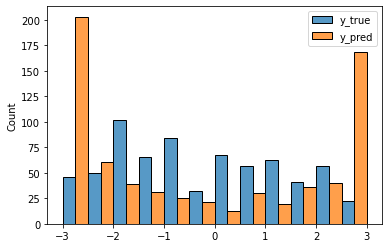

In [16]:
# distribution comparison: the reason MAE is trash
import seaborn as sns
df_real = pd.DataFrame({'y_true': text_data['labels'], 'y_pred': scaled_predictions})
sns.histplot(
    data=df_real, multiple='dodge',
    bins=np.arange(-3, 3 + 0.5, 0.5))

In [17]:
thing = df_real['y_true'] - df_real['y_pred']
# this shows how different the vals are, to see where there is a lot of disagreemnt
# these are most interesting to put into shap values

In [23]:
import shap
explainer = shap.Explainer(pred, tokenizer)

In [33]:
# MAKE SURE TO PASS A LIST OR YOU WILL BE SAD, EVEN FOR 1 STRING
# shap_values = explainer(list(text_data['text'][0:2]))
shap_values = explainer([text_data['text'][4]])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [35]:
import shap.plots
shap.plots.text(shap_values[0,:,'LABEL_0'])